### Imports

In [91]:
from fastai.vision.all import *
from tqdm import tqdm
import albumentations as A
from functools import partial
from assets.chiputility import *
from datetime import datetime

%matplotlib inline

### Setup

In [2]:
#DATA_PATH = Path('/driven-data/cloud-cover')
DATA_PATH = Path('data')
TRAIN_PATH = DATA_PATH / 'train_features'
LABEL_PATH = DATA_PATH / 'train_labels'
MODEL_REF = 'pretrain_440_res34'

In [3]:
#trouble_chips = np.load('data/trouble_chips.npy', allow_pickle = True)
#print(len(trouble_chips))

In [4]:
df = pd.read_csv('data/train_new_split.csv', index_col = 0)
#df = df[~df['chip_id'].isin(trouble_chips)]

In [5]:
def split_df(df):
    loc_counts = df.value_counts('location')
    
    big_locs = loc_counts[loc_counts > 150].index.tolist()
    small_locs = loc_counts[loc_counts <= 150].index.tolist()
    
    n_big_locs = len(big_locs)
    n_small_locs = len(small_locs)
    n_chosen_big_locs = int(0.2 * n_big_locs)
    n_chosen_small_locs = int(0.2 * n_small_locs)

    chosen_big_locs = np.random.choice(big_locs, size = n_chosen_big_locs)
    chosen_small_locs = np.random.choice(small_locs, size = n_chosen_small_locs)
    chosen_locs = list(chosen_big_locs) + list(chosen_small_locs)
    print(f'Chosen {len(chosen_locs)} of {len(df.location.unique())} locations {len(chosen_locs)/len(df.location.unique()):3.2f}%.')
    
    n_loc_inst = len(df[df.location.isin(chosen_locs)])
    pct_loc_inst = n_loc_inst / len(df) * 100
    print(f'Chosen {n_loc_inst} of {len(df)} instances which makes it {pct_loc_inst:3.2f}%')
    
    df['is_valid'] = False
    df.loc[df['location'].isin(chosen_locs), 'is_valid'] = True
    
    return df

In [6]:
IMG_SIZE = 512
BS = 2
DEBUG = False ## Size of development set or None 

### Augmentations
The visual augmentations only modify the 3 visual bands. When using mean/std normalization those augmentations tend to result in an image, that consists of zeros. Thus the benefits of those augmentations have to be weightet against the performance gain, that mean/std normalization seems to give.

In [7]:
class OnlyVizAlbumentationsTransform(Transform):
    split_idx = 0
    def __init__(self, aug):
        self.aug = aug
    def encodes(self, x):
        if len(x.shape) > 2:
            non_viz_channels = x[...,3:]
            viz_aug = self.aug(image=x[...,:3].astype(np.float32))['image']
            return np.concatenate([viz_aug,non_viz_channels], axis = -1)
        else:
            return x

class SegmentationAlbumentationsTransform(ItemTransform):
    split_idx = 0
    def __init__(self, aug): 
        self.aug = aug
    def encodes(self, x):
        augs = []
        for img,mask in x:
            augs.append(tuple(self.aug(image=img, mask=mask).values()))
        return augs

class TransposeTransform(ItemTransform):
    def encodes(self, x):
        transposed = []
        for img, mask in x:
            transposed.append((TensorImage(img.transpose(2,0,1)).float(), TensorMask(mask).long()))
        return transposed

class FormatTransform(ItemTransform):
    def __init__(self, return_type):
        self.return_type = return_type
    def encodes(self, x):
        return self.return_type([TensorImage(x[0].permute(0,3,1,2)).float(), TensorMask(x[1]).long()])

## Visual augmentation seems to break the images (all 0) with the mean/std normalization
viz_augs_list = A.Compose([
    A.HueSaturationValue(
        hue_shift_limit=0,
        sat_shift_limit=0,
        val_shift_limit=0,
        p = 0.5
    ),
    #A.Normalize(max_pixel_value = 1),
    A.RandomBrightnessContrast(),
])
    
geom_augs_list = A.Compose([
     A.Flip(),
     A.RandomCrop(IMG_SIZE, IMG_SIZE, always_apply = True) if IMG_SIZE != 512 else None,
     A.RandomGridShuffle(grid = (2,2), p = 0.3),
     A.CoarseDropout(mask_fill_value = 0),
    ])

viz_augs_tfms = OnlyVizAlbumentationsTransform(viz_augs_list)
geom_augs_tfms = SegmentationAlbumentationsTransform(geom_augs_list)
transpose_tfm = TransposeTransform()
format_tfm = FormatTransform(tuple)

### Load chips and dataloaders

In [8]:
chips = Chips(TRAIN_PATH, df, debug = DEBUG)
tfms = [[get_multiband_img], [partial(get_mask, label_path =LABEL_PATH)]]
dsets = Datasets(chips.paths, tfms, splits = chips.get_splits())

dls = dsets.dataloaders(
    bs = BS, 
    num_workers = 4, 
    pin_memory = True,
    device = 'cuda',
    #after_item = [viz_augs_tfms],
    before_batch = [geom_augs_tfms, transpose_tfm],# 
    #after_batch = [],
)

In [121]:
meta_dict = {
    'maxs': {'B02': 27600.0, 'B03': 26096.0, 'B04': 23104.0, 'B08': 19568.0},
    'means': {'B02': 2848.064, 'B03': 2839.087, 'B04': 2741.289, 'B08': 3657.909},
    'stds': {'B02': 3156.927, 'B03': 2899.28, 'B04': 2789.962, 'B08': 2424.189}
}

def get_multiband_img(chip_path):
    # Normalization by mean/std
    blue  = (get_array(chip_path, 'B02') - meta_dict['means']['B02']) / meta_dict['stds']['B02']
    green = (get_array(chip_path, 'B03') - meta_dict['means']['B03']) / meta_dict['stds']['B03']
    red   = (get_array(chip_path, 'B04') - meta_dict['means']['B04']) / meta_dict['stds']['B04']
    infra = (get_array(chip_path, 'B08') - meta_dict['means']['B08']) / meta_dict['stds']['B08']
    
    stack = np.stack([red, green, blue, infra], axis = -1) # resulting size:(width,height,bands)
    return stack

def show_b(b, ax = None, ctx = None, figsize = (15,15), title = None, alpha = 0.3, **kwargs):
    """
    Multiplies the mask into the yellow channel of the image with a factor of `alpha`.
    Adds the countours of the mask to the shown image
    """
    img, msk = b
    img = img.cpu().numpy()[:3].transpose(1,2,0)
    img_min = img.min(axis = (0,1))
    img_max = img.max(axis = (0,1))
    img = (img - img_min) / (img_max - img_min)
    
    msk = msk.cpu().numpy().astype(np.uint8)
    contour = np.array(Image.fromarray(msk).filter(ImageFilter.FIND_EDGES))
    #img[...,2] *= (1 - alpha * msk)
    img[np.where(contour)] = (0.7,0.1,0.3)
    
    ax = ifnone(ax,ctx)
    if ax is None:
        _,ax = plt.subplots(figsize = figsize)
    ax.imshow(img, **kwargs)
    if title is not None: ax.set_title(title)
    ax.axis('off')
    return ax

@typedispatch
def show_batch(x, y, samples, ctxs=None, max_n=9, **kwargs):
    if ctxs is None: 
        ctxs = Inf.nones
    ctxs = [show_b(b, ctx = c, **kwargs) for b,c,_ in zip(samples,ctxs,range(max_n))]
    return ctxs

torch.Size([2, 4, 512, 512])


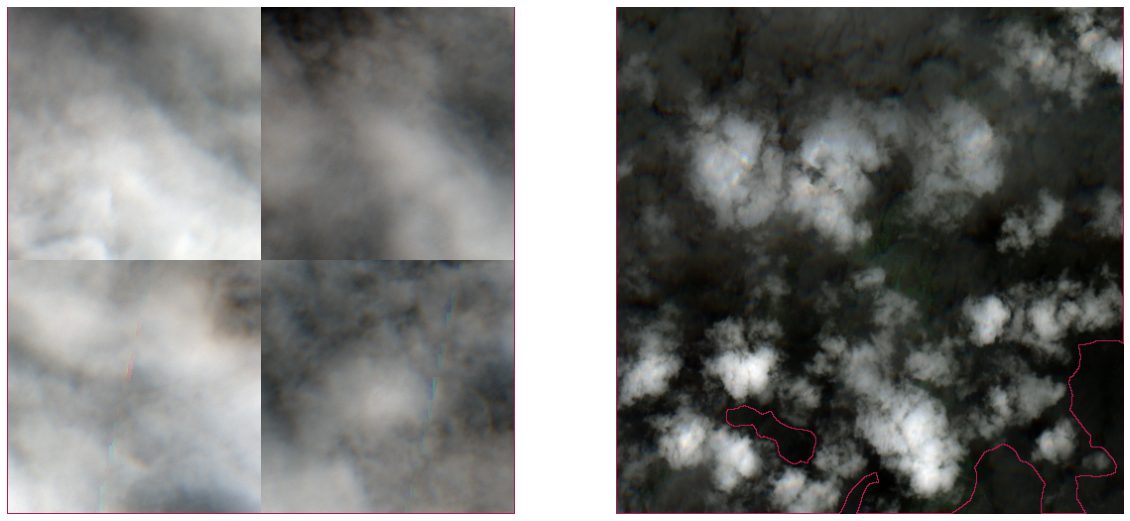

In [122]:
b = dls.one_batch()
print(b[0].shape)
AA = dls.show_batch(b = b, figsize = (20, 10))

### Build model and learn

In [11]:
n_channels, *img_size = dls.one_batch()[0].shape[-3:]

model = create_unet_model(
    arch = resnet34,
    #arch = resnet50,
    n_out = 2,
    img_size = img_size,
    n_in = n_channels
)

_default_meta    = {'cut':None, 'split':default_split}
meta = model_meta.get(resnet34, _default_meta)

learn = Learner(
    dls,
    model,
    loss_func = CrossEntropyLossFlat(axis = 1),##model returns preds w/ shape: (2,w,h); where 1st axis holds (p,1-p)
    metrics = [Dice, JaccardCoeff],
    splitter = meta['split'],
    wd = 0.001
).to_fp16()

### Load model that was pretrained on 440 image size

In [11]:
learn.load(MODEL_REF)

SuggestedLRs(valley=9.120108734350652e-05)

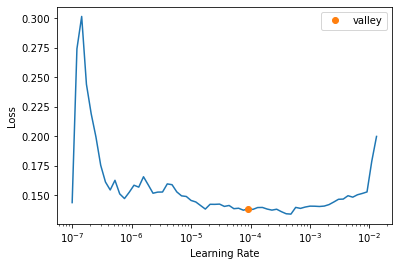

In [13]:
learn.freeze()
learn.lr_find()

In [ ]:
start = datetime.now()
print(f'Training started at: {start.strftime("%H:%M:%S")}')
learn.fine_tune(
    15,
    7e-5,
    freeze_epochs = 1,
    cbs = [SaveModelCallback(), EarlyStoppingCallback(monitor='jaccard_coeff', comp=np.greater, patience=3)]
)
end = datetime.now()
print(f'Training ended at: {end.strftime("%H:%M:%S")}')

Training started at: 15:21:01


epoch,train_loss,valid_loss,dice,jaccard_coeff,time
0,0.155339,0.114247,0.961886,0.926571,29:08


Better model found at epoch 0 with valid_loss value: 0.11424726247787476.


epoch,train_loss,valid_loss,dice,jaccard_coeff,time
0,0.147682,0.112636,0.962236,0.927220,24:21
1,0.140014,0.114354,0.961570,0.925984,24:25
2,0.132050,0.115521,0.961528,0.925907,28:08
3,0.138018,0.110851,0.962962,0.928569,21:55


Better model found at epoch 0 with valid_loss value: 0.11263629049062729.
Better model found at epoch 3 with valid_loss value: 0.11085113137960434.


### Compare the predictions to ground truth:

In [230]:
@typedispatch
def show_res(x, y, samples, outs, ctxs=None, max_n=9, **kwargs):
    figsize = kwargs.get('figsize')
    
    if ctxs is None: 
        ctxs = get_grid(min(len(samples), max_n)*2, nrows=None, ncols=2, figsize= figsize, flatten = False)
    outs = outs.map(detuplify)
    preds = L((r[0],s) for r,s in zip(samples,outs))
    o_ctxs = []
    for i in range(min(len(samples[0]), max_n)):
        ctxs[i][0] = show_b(samples[i], ctx = ctxs[i][0], **kwargs)
        ctxs[i][0].set_title('Ground Truth:')
        ctxs[i][1] = show_b(preds[i], ctx=ctxs[i][1], **kwargs)
        ctxs[i][1].set_title('Prediction:')
    return ctxs

@patch 
def show_results(self:TfmdDL, b, out, max_n=9, ctxs=None, show=True, **kwargs):
    x,y,its = self.show_batch(b, max_n=max_n, show=False)
    
    b_out = type(b)(tuple(b[:self.n_inp]) + (tuple(out) if is_listy(out) else (out,)))
    x1,y1,outs = self.show_batch(b_out, max_n=max_n, show=False)
    
    res = (x,x1,None,None) if its is None else (x, y, its, outs.itemgot(slice(self.n_inp,None)))
    
    if not show: return res
    show_res(*res, ctxs=ctxs, max_n=max_n, **kwargs)

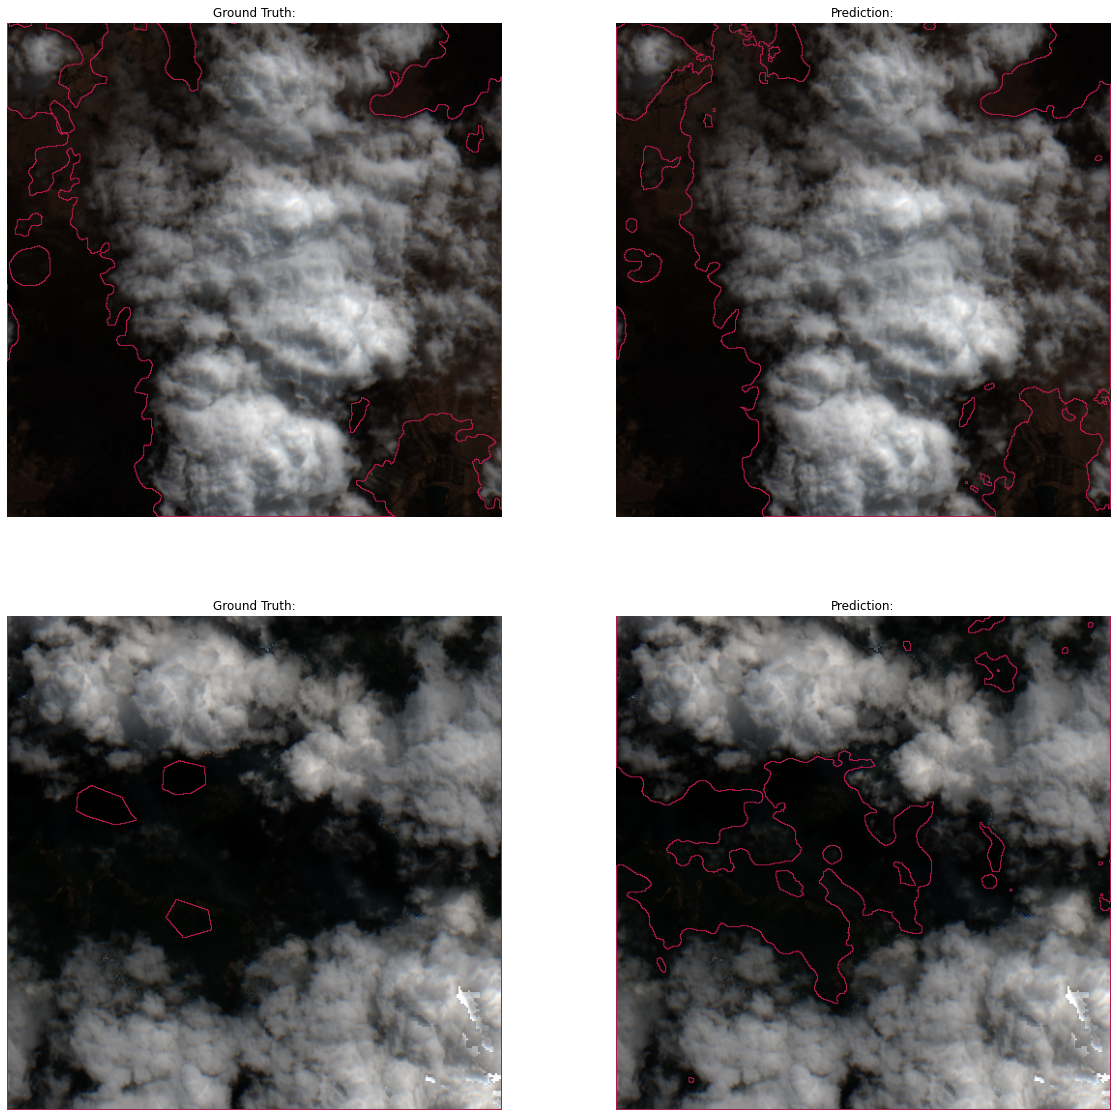

In [231]:
learn.show_results(figsize = (20,20))

### Visually the predictions actually look better than some of the ground truth due to inconsistent labeling. Tiny spots that don't seem to match can be removed in postprocessing.

In [ ]:
learn.to_fp32()
learn.export('from_pretrain_512_res34')
learn.save('from_pretrain_512_res34')